# Regressionsanalyse zur Vorhersage von Powerlifting-Ergebnissen im Flachbankdrücken

Von Lukas Borawski (939068) und Fukarn Dogan (939766)

## Importe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

## Data


### Laden der Daten

In [2]:
rawdata = pd.read_csv("Data.csv")
rawdata.head()
#rawdata.describe()

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0,125.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0,157.5
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0,145.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5,60.0
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.5,60.0


### Visualisierung der Daten

In [3]:
# Anzahl der Einträge ausgeben
num_entries = rawdata.shape[0]
print("Anzahl der Einträge in Rawdata:", num_entries)

# Eindeutige Kategorien ausgeben
unique_categories = rawdata["Equipment"].unique()
print("Kategorien in der Spalte von Eqipment:", unique_categories)  

# Überprüfen ob Diverse Geschlechter inkludiert sind
unique_categories = rawdata["Sex"].unique()
print("Kategorien in der Spalte von Eqipment:", unique_categories)  

# Altersspanne berechnen
print("Altersspanne der Teilnehmer:", rawdata["Age"].min(), "-", rawdata["Age"].max())

# Gewichtsspanne berechnen
print("Körpergewicht der Teilnehmer:", rawdata["BodyweightKg"].min(), "-", rawdata["BodyweightKg"].max())

# Verhältnis Frauen und Männer
count_men = (rawdata['Sex'] == 'M').sum()
count_women = (rawdata['Sex'] == 'F').sum()

# Berechnung
percentage_men = (count_men / len(rawdata)) * 100
percentage_women = (count_women / len(rawdata)) * 100
print(round(percentage_men, 2), "% der Teilnehmer sind männlich und", round(percentage_women, 2), "% der Teilnehmer sind weiblich")


Anzahl der Einträge in Rawdata: 18900
Kategorien in der Spalte von Eqipment: ['Raw' 'Wraps' 'Single-ply' 'Multi-ply']
Kategorien in der Spalte von Eqipment: ['M' 'F']
Altersspanne der Teilnehmer: 7.0 - 83.0
Körpergewicht der Teilnehmer: 26.13 - 201.0
67.57 % der Teilnehmer sind männlich und 32.43 % der Teilnehmer sind weiblich


Erläuterung des Equipments:<br>
__Raw__ = Powerlifter verwenden kein Equipment<br>__Wraps__ = Athleten verwenden spezielle Bandagen für zusätzliche Stabilität an Knie oder Handgelenken <br>__Single-ply__ = Athleten tragen vollständige Ausrüstung, jedoch ist jede Schicht auf eine begrenzt.<br>__Multi-ply__ = Athleten tragen vollständige Ausrüstung mit mehreren erlaubten Schichten für maximale Unterstützung.



## Datenverarbeitung

### Fehlende Werte

In [4]:
# Überprüfen auf fehlende Werte
print(rawdata.isnull().sum())
num_entries = rawdata.shape[0]
print("Anzahl der Einträge in Rawdata:", num_entries, "\n")

# Da weniger als 1% der Daten unvollstänidg sind = Zeilen löschen
rawdata = rawdata.dropna(axis=0)

# Wiederholtes Überprüfen auf fehlende Werte
print(rawdata.isnull().sum())
num_entries = rawdata.shape[0]
print("Anzahl der Einträge in Rawdata:", num_entries, "\n")


playerId            0
Name                0
Sex                 0
Equipment           0
Age               175
BodyweightKg        0
BestSquatKg         0
BestDeadliftKg      0
BestBenchKg         0
dtype: int64
Anzahl der Einträge in Rawdata: 18900 

playerId          0
Name              0
Sex               0
Equipment         0
Age               0
BodyweightKg      0
BestSquatKg       0
BestDeadliftKg    0
BestBenchKg       0
dtype: int64
Anzahl der Einträge in Rawdata: 18725 



### Sonderfall BestSquatKg

In [5]:
rawdata.select_dtypes(include='object').describe()

,Name,Sex,Equipment,BestSquatKg
count,18725,18725,18725,18725
unique,15758,2,4,624
top,Scott Layman,M,Raw,182.5
freq,8,12643,12167,362


Wir haben bemerkt, dass die Spalte "BestSquatKg" als String formatiert ist. Jedoch müsste es sich bei Kilogramm um einen Integer oder eine Zeichenkette (float) handeln. Daher muss diese Spalte vor der weiteren Verarbeitung angepasst werden.

In [6]:
# Identifizierung der Einträge mit nicht-numerischen Werten in "BestSquatKg"
non_numeric_entries = pd.to_numeric(rawdata['BestSquatKg'], errors='coerce').isna()

# Ausgabe der fehlerhaften Einträge
print(rawdata[non_numeric_entries][['playerId', 'BestSquatKg']],"\n")

       playerId BestSquatKg
94      11462.0      102..5
1614    21517.0      227..5
1663    12116.0      133..0
1720    28706.0      192..5
1766    23256.0      105..0
2590    12648.0      195..0
2803    20917.0      237..5
4213     1659.0      122..5
9712    24353.0      295..0
12138   17751.0      180..0
12429   16459.0      205..0
12445   14456.0      110..0
12664   13558.0      220..0
16998     545.0      145..0
18527    5539.0      207..5 



Einige Werte wurden mit einem Punkt zu viel gespeichert, also ersetzen wir diese Werte mit nur einem Punkt um Float-Werte zu erhalten.


In [7]:
# Korrektur der fehlerhaften Einträge
rawdata['BestSquatKg'] = rawdata['BestSquatKg'].str.replace('..', '.', regex=False)

# Konvertierung der korrigierten Spalte in einen numerischen Typ
rawdata['BestSquatKg'] = pd.to_numeric(rawdata['BestSquatKg'])

# Ausgabe der fehlerhaften Einträge
print(rawdata[non_numeric_entries][['playerId', 'BestSquatKg']],"\n")

       playerId  BestSquatKg
94      11462.0        102.5
1614    21517.0        227.5
1663    12116.0        133.0
1720    28706.0        192.5
1766    23256.0        105.0
2590    12648.0        195.0
2803    20917.0        237.5
4213     1659.0        122.5
9712    24353.0        295.0
12138   17751.0        180.0
12429   16459.0        205.0
12445   14456.0        110.0
12664   13558.0        220.0
16998     545.0        145.0
18527    5539.0        207.5 



Wir haben ebenfalls festgestellt, dass einige Werte in dieser Spalte mit einem negativen Wert gespeichert worden. Da dies bei einem Powerlifting Wettbewerb gar nicht möglich ist, müssen wir auch diese Werte behandeln.

In [8]:
# Zählen der negativen Werte
count_of_negative_rows = (rawdata['BestSquatKg'] < 0).sum()
print("Anzahl der Zeilen mit negativen Werten in 'BestSquatKg':", count_of_negative_rows)

num_entries = rawdata.shape[0]
print("Anzahl der Einträge in Rawdata:", num_entries, "\n")

# Entfernen der Zeilen mit negativen Werten in "BestSquatKg"
rawdata = rawdata[rawdata['BestSquatKg'] >= 0]

# Überprüfung 
count_of_negative_rows_updated = (rawdata['BestSquatKg'] < 0).sum()
print("Anzahl der Zeilen mit negativen Werten in 'BestSquatKg' nach Anpassung:", count_of_negative_rows_updated)

num_entries = rawdata.shape[0]
print("Anzahl der Einträge in Rawdata:", num_entries, "\n")

## Unser erster Ansatz war es die negativen Werte in positive umzuwandeln, indem wir diese in absolute Zahlen transformieren.
## Da es sich jedoch nur um 82 Werte handelt, habe wir entschieden diese zu entfernen.


Anzahl der Zeilen mit negativen Werten in 'BestSquatKg': 82
Anzahl der Einträge in Rawdata: 18725 

Anzahl der Zeilen mit negativen Werten in 'BestSquatKg' nach Anpassung: 0
Anzahl der Einträge in Rawdata: 18643 



### Außreißer


#### Visualisierung

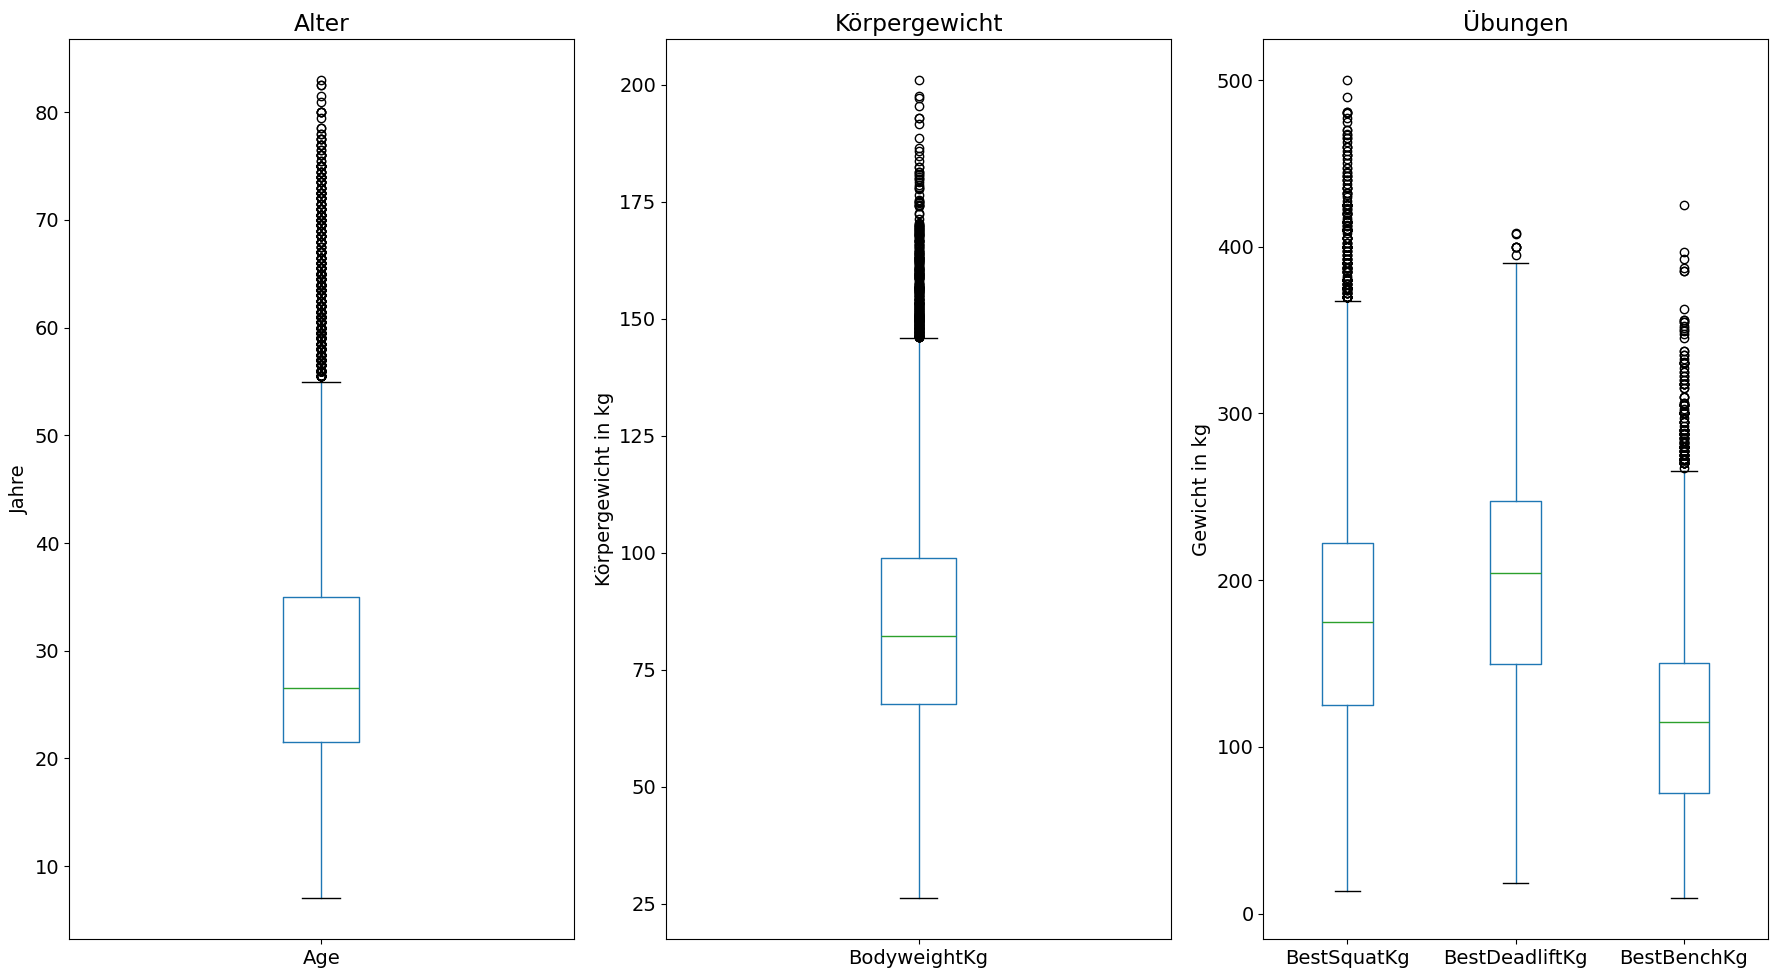

In [9]:
# Formatierung
plt.figure(figsize=(18, 10)) 
plt.rc('font', size=14)  

"""
# Subplot = Alle
plt.subplot(2, 3, 1)
rawdata.drop(columns=['playerId']).boxplot(grid=False)
plt.ylabel('Werte')
plt.title('Alle')
"""
# Subplot = Alter
plt.subplot(1, 3, 1)
rawdata.boxplot(column=['Age'], grid=False)
plt.ylabel('Jahre')
plt.title('Alter')

# Subplot = Körpergewicht
plt.subplot(1, 3, 2)
rawdata.boxplot(column=['BodyweightKg'], grid=False)
plt.ylabel('Körpergewicht in kg')
plt.title('Körpergewicht')

# Subplot = Übungen
plt.subplot(1, 3, 3)
rawdata.boxplot(column=['BestSquatKg', 'BestDeadliftKg', 'BestBenchKg'], grid=False)
plt.ylabel('Gewicht in kg')
plt.title('Übungen')

# Ausgabe
plt.tight_layout()
plt.show()


#### Anpassung

In [10]:
def handle_outliers(column_name, dataframe):
    # Festlegen der Interquantile
    Q1 = dataframe[column_name].quantile(q=0.15, interpolation='midpoint')
    Q3 = dataframe[column_name].quantile(q=0.85, interpolation='midpoint')
    IQR = Q3 - Q1
    
    # Upper bound
    upper_bound = Q3 + 1.5 * IQR
    upper_outliers = (dataframe[column_name] > upper_bound)
    print(f"Sum of upper outliers for {column_name}: ", upper_outliers.sum())
    
    # Lower bound
    lower_bound = Q1 - 1.5 * IQR
    lower_outliers = (dataframe[column_name] < lower_bound)
    print(f"Sum of lower outliers for {column_name}: ", lower_outliers.sum())
    
    # Setting outliers to boundaries
    dataframe.loc[upper_outliers, column_name] = upper_bound
    dataframe.loc[lower_outliers, column_name] = lower_bound

# Anwenden der Funktion für die ausgewählten Variablen
columns_to_handle = ['Age', 'BodyweightKg', 'BestSquatKg', 'BestDeadliftKg', 'BestBenchKg']
for column in columns_to_handle:
    handle_outliers(column, rawdata)

Sum of upper outliers for Age:  45
Sum of lower outliers for Age:  0
Sum of upper outliers for BodyweightKg:  24
Sum of lower outliers for BodyweightKg:  0
Sum of upper outliers for BestSquatKg:  10
Sum of lower outliers for BestSquatKg:  0
Sum of upper outliers for BestDeadliftKg:  0
Sum of lower outliers for BestDeadliftKg:  0
Sum of upper outliers for BestBenchKg:  28
Sum of lower outliers for BestBenchKg:  0


### Dummifizierung

In [11]:
# Anpassen der Spalte Equipment
rawdata = pd.get_dummies(rawdata, columns=["Equipment"])
rawdata = pd.get_dummies(rawdata, columns=["Sex"])

# Ausgabe der ersten fünf Zeilen
rawdata[['Equipment_Raw', 'Equipment_Wraps', 'Equipment_Single-ply', 'Equipment_Multi-ply', 'Sex_M', 'Sex_F']].head()

,Equipment_Raw,Equipment_Wraps,Equipment_Single-ply,Equipment_Multi-ply,Sex_M,Sex_F
0,True,False,False,False,True,False
1,False,True,False,False,True,False
2,True,False,False,False,True,False
3,True,False,False,False,False,True
4,True,False,False,False,False,True


In [12]:
## Zwischenstand
rawdata.head()

,playerId,Name,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps,Sex_F,Sex_M
0,19391.0,Carlos Ceron,23.0,87.30,205.0,235.0,125.0,False,True,False,False,False,True
1,15978.0,Tito Herrera,23.0,73.48,220.0,260.0,157.5,False,False,False,True,False,True
2,27209.0,Levi Lehman,26.0,112.40,142.5,220.0,145.0,False,True,False,False,False,True
3,27496.0,Stacy Hayford,35.0,59.42,95.0,102.5,60.0,False,True,False,False,True,False
4,20293.0,Brittany Hirt,26.5,61.40,105.0,127.5,60.0,False,True,False,False,True,False


### Korrelationen

#### Ohne Equipment


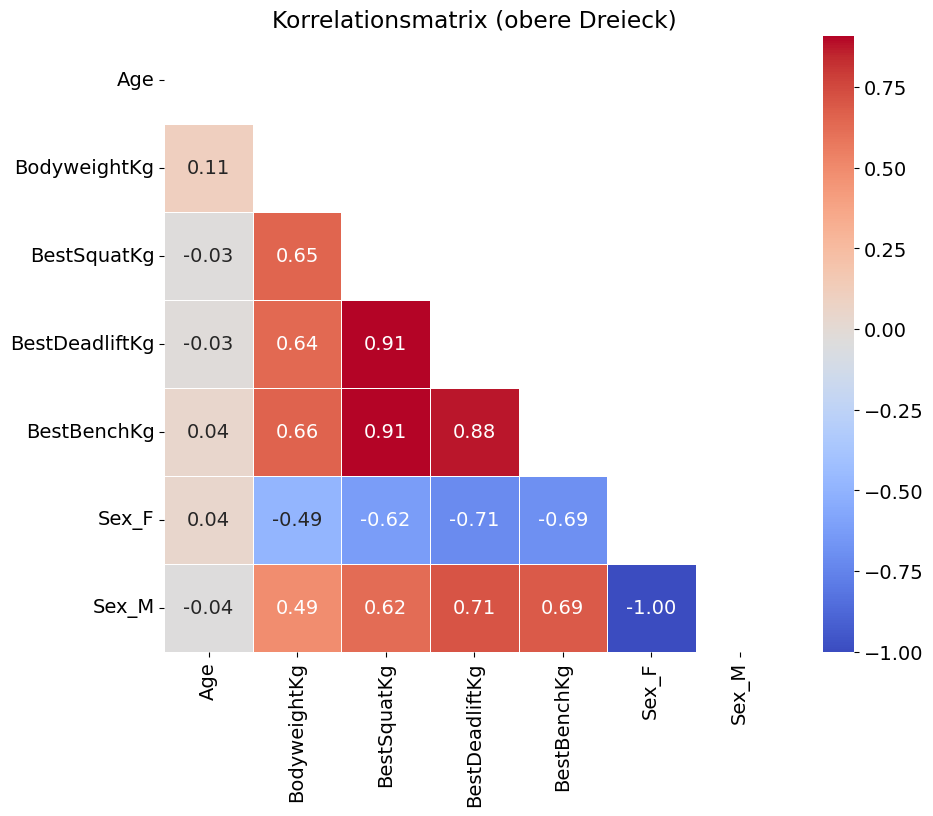

In [13]:
# Entfernen von unwichtigen Spalten
numerical_data2 = rawdata.drop(columns=['Name', 'playerId','Equipment_Raw', 'Equipment_Wraps', 'Equipment_Single-ply', 'Equipment_Multi-ply',])

# Berechnung der Korrelationsmatrix
correlation_matrix = numerical_data2.corr()

# Erstellen der Heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korrelationsmatrix (obere Dreieck)')
plt.show()

#### Mit Equipment

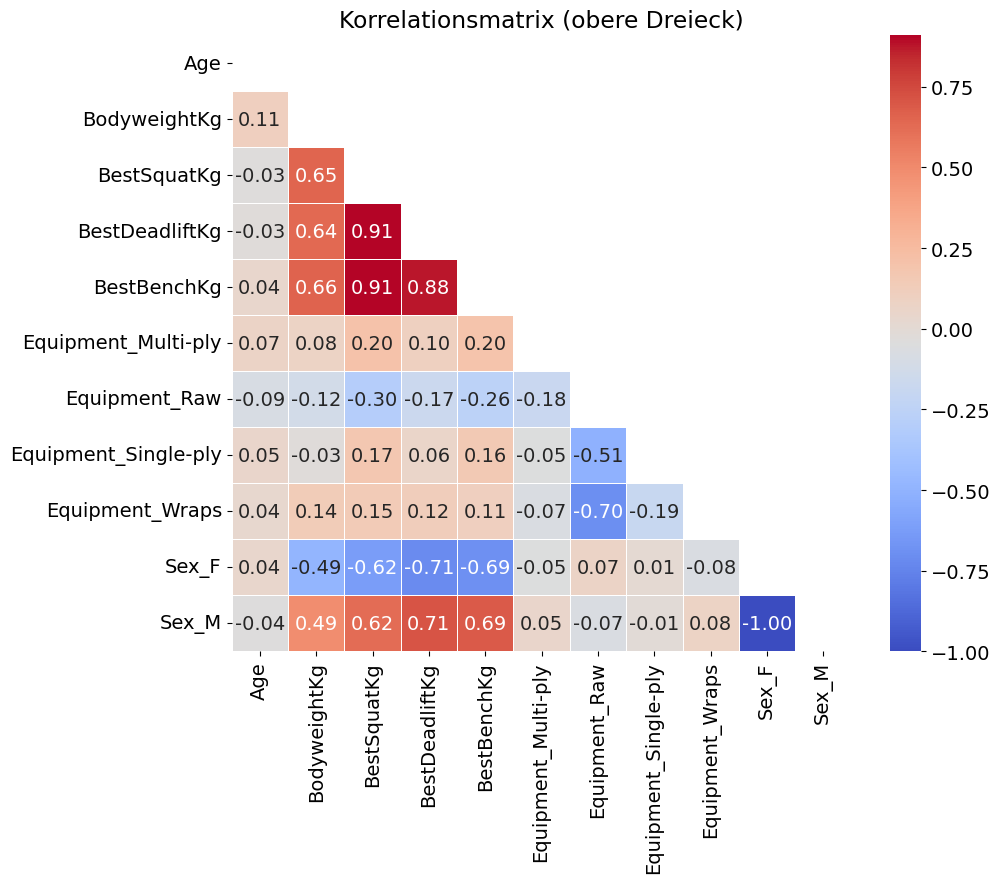

In [14]:
# Entfernen von unwichtigen Spalten
numerical_data2 = rawdata.drop(columns=['Name', 'playerId'])

# Berechnen der Korrelationsmatrix
correlation_matrix = numerical_data2.corr()

# Erstellen der Heatmap mit nur einer Hälfte der Korrelationsmatrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korrelationsmatrix (obere Dreieck)')
plt.show()

### Erstellung von Trainings und Test Sets

In [15]:
# Extract X and y
X = rawdata.drop(columns=['playerId', 'Name', 'BestBenchKg'])
y = rawdata['BestBenchKg']

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalieren der Features und Zielvariablen separat
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

## Neurales Netzwerk Modell

### Definition und Training

In [16]:
# Definition
inputs = Input(shape=(X_train_scaled.shape[1],))
hidden = Dense(units=128, activation='relu')(inputs)
hidden = Dense(units=64, activation='relu')(hidden)
hidden = Dense(units=32, activation='relu')(hidden)
hidden = Dense(units=16, activation='relu')(hidden)
outputs = Dense(units=1, activation='linear')(hidden)

model = Model(inputs=inputs, outputs=outputs, name='Regression')

# Konfiguration des Trainingsprozesses
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Modelltraining
model.fit(x=X_train_scaled, y=y_train_scaled, epochs=5, batch_size=4)

Epoch 1/5
3729/3729 ━━━━━━━━━━━━━━━━━━━━ 3s 514us/step - loss: 0.0048 - root_mean_squared_error: 0.0690
Epoch 2/5
3729/3729 ━━━━━━━━━━━━━━━━━━━━ 2s 516us/step - loss: 0.0036 - root_mean_squared_error: 0.0603
Epoch 3/5
3729/3729 ━━━━━━━━━━━━━━━━━━━━ 2s 517us/step - loss: 0.0034 - root_mean_squared_error: 0.0581
Epoch 4/5
3729/3729 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step - loss: 0.0032 - root_mean_squared_error: 0.0567
Epoch 5/5
3729/3729 ━━━━━━━━━━━━━━━━━━━━ 2s 515us/step - loss: 0.0032 - root_mean_squared_error: 0.0567


### Test-Durchläufe

#### Test 1
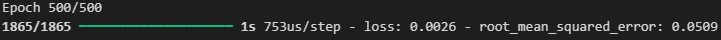<br>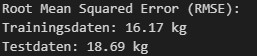
#### Test 2
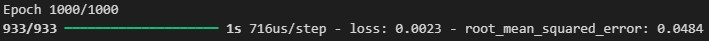<br>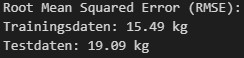
#### Test 3
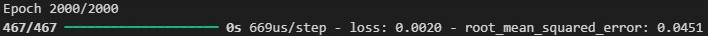<br>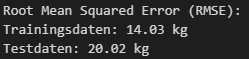
#### Test 4
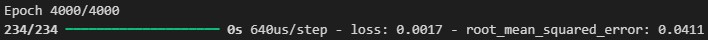<br>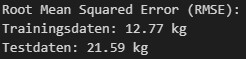

## Vorhersagen

In [17]:
# Definition des RMSE
def rmse(actuals, preds):
    """Root mean squared error (RMSE)

    Arguments
    ---------
        actuals : vector-like, e.g. list, tupel, array
            A numeric vector with actual values.
        preds : vector-like, e.g. list, tupel, array
            A numeric vector with predicted values.

    Returns
    -------
       Root mean squared error : numpy.float
    """
    actuals, preds = np.array(actuals), np.array(preds)
    error = actuals - preds
    mse = np.mean(error**2)
    return np.sqrt(mse)

# Vorhersagen für Trainings- und Testdaten
train_yhat_scaled = model.predict(X_train_scaled)
test_yhat_scaled = model.predict(X_test_scaled)

# Umkehrung der Skalierung für Vorhersagen
train_yhat = scaler_y.inverse_transform(train_yhat_scaled)
test_yhat = scaler_y.inverse_transform(test_yhat_scaled)

# Berechnung des RMSE
rmse_train = rmse(y_train.values, train_yhat.flatten())
rmse_test = rmse(y_test.values, test_yhat.flatten())

# Ausgabe der RMSE-Werte für Trainings- und Testdaten
print("Root Mean Squared Error (RMSE):")
print("Trainingsdaten: {:.2f} kg".format(rmse_train))
print("Testdaten: {:.2f} kg".format(rmse_test))

467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
Root Mean Squared Error (RMSE):
Trainingsdaten: 19.38 kg
Testdaten: 19.61 kg


### Visualisierungen

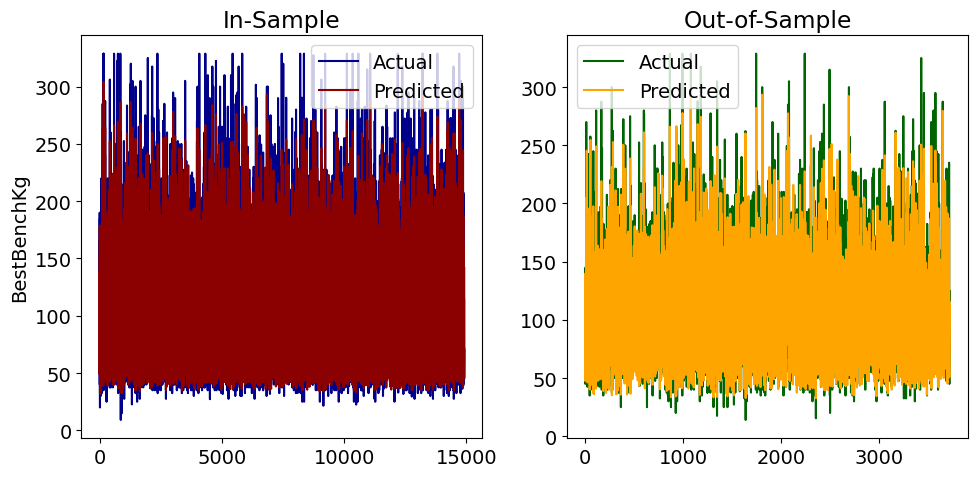

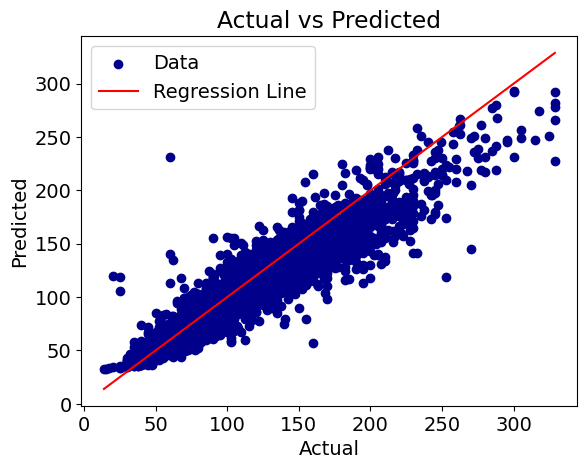

In [18]:
# Visualisierung der Vorhersagen
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# In-Sample
axes[0].plot(y_train.values, label='Actual', linestyle='solid', color='darkblue')
axes[0].plot(train_yhat.flatten(), label='Predicted', linestyle='solid', color='darkred')
axes[0].set_title("In-Sample")
axes[0].set_ylabel('BestBenchKg')
axes[0].legend()

# Out-of-Sample 
axes[1].plot(y_test.values, label='Actual', linestyle='solid', color='darkgreen')
axes[1].plot(test_yhat.flatten(), label='Predicted', linestyle='solid', color='orange')
axes[1].set_title("Out-of-Sample")
axes[1].legend()

plt.tight_layout()
plt.show()

# Scatterplot der tatsächlichen und vorhergesagten Werte
plt.scatter(y_test.values, test_yhat.flatten(), color='darkblue', label='Data')

# Regressionsgerade
x_line = np.linspace(min(y_test.values), max(y_test.values), 100)
plt.plot(x_line, x_line, color='red', linestyle='solid', label='Regression Line')

plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

## Regressionsanalyse

In [19]:
# Regressionsmodell anpassen
regmodel = LinearRegression().fit(X=X_train, y=y_train)

# Modellparameter
r_sq = round(regmodel.score(X_train, y_train), 2)
print(f"Coefficient of determination: {r_sq}")
print(f"Intercept: {[round(item, 2) for item in regmodel.intercept_.reshape(-1)]}")
coefficients = dict(zip(rawdata.columns.to_list()[1:], [round(item, 2) for item in regmodel.coef_.reshape(-1)]))
print(f"Coefficients: {coefficients}")

# RMSE
yhat = regmodel.predict(X_train)
print(f"RMSE: {round(rmse(y_train, yhat), 2)}")

Coefficient of determination: 0.87
Intercept: [-10.37]
Coefficients: {'Name': 0.22, 'Age': 0.21, 'BodyweightKg': 0.41, 'BestSquatKg': 0.16, 'BestDeadliftKg': 13.63, 'BestBenchKg': -7.05, 'Equipment_Multi-ply': 1.85, 'Equipment_Raw': -8.43, 'Equipment_Single-ply': -8.54, 'Equipment_Wraps': 8.54}
RMSE: 18.68


## Quellen

- https://www.kaggle.com/datasets/kukuroo3/powerlifting-benchpress-weight-predict
- https://www.kaggle.com/code/yasseinmahmoud/eda-benchpress-weight
- https://chat.openai.com/
- https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet
- https://learn.fh-kiel.de/course/view.php?id=7061